In [22]:
# 1️⃣ IMPORTS
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import joblib
import re
import string

In [23]:
# 2️⃣ AUTO-DETECT KAGGLE OR LOCAL ENVIRONMENT
kaggle_input_root = '/kaggle/input/flipkart-data'
local_dataset = 'flipkart_reviews.csv'

DATA_PATH = None

if os.path.exists(kaggle_input_root):
    print("🟢 Detected Kaggle environment.")
    csv_files = []
    for root, dirs, files in os.walk(kaggle_input_root):
        for f in files:
            if f.endswith('.csv'):
                csv_files.append(os.path.join(root, f))

    if len(csv_files) > 0:
        print("\n📂 Found the following CSV files in /kaggle/input/:")
        for i, path in enumerate(csv_files, 1):
            print(f"{i}. {path}")

        DATA_PATH = csv_files[0]  # Auto-select first CSV
        print(f"\n✅ Using dataset: {DATA_PATH}")
    else:
        raise FileNotFoundError(
            "❌ No CSV files found in /kaggle/input/. Please upload your dataset via the right-side 'Add data' panel."
        )
else:
    print("🟡 Running locally.")
    if not os.path.exists(local_dataset):
        raise FileNotFoundError(
            f"❌ Local dataset '{local_dataset}' not found. Please place it in the same folder."
        )
    DATA_PATH = local_dataset
    print(f"✅ Using local dataset: {DATA_PATH}")

🟢 Detected Kaggle environment.

📂 Found the following CSV files in /kaggle/input/:
1. /kaggle/input/flipkart-data/flipkart_data.csv

✅ Using dataset: /kaggle/input/flipkart-data/flipkart_data.csv


In [24]:
# 3️⃣ LOAD DATA
df = pd.read_csv(DATA_PATH)
print('\n📊 Dataset loaded successfully!')
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# =========================================================
# 4️⃣ DETECT TEXT AND LABEL COLUMNS
# =========================================================
TEXT_COL = None
LABEL_COL = None

CAND_TEXT = ['review', 'reviews', 'text', 'review_text', 'content']
for c in CAND_TEXT:
    if c in df.columns:
        TEXT_COL = c
        break

if TEXT_COL is None:
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    if obj_cols:
        TEXT_COL = obj_cols[0]
        print(f"⚠️ No typical text column found; using '{TEXT_COL}'.")
    else:
        raise ValueError('❌ No text column detected. Please check your dataset.')

if 'sentiment' in df.columns:
    LABEL_COL = 'sentiment'
elif 'label' in df.columns:
    LABEL_COL = 'label'
elif 'rating' in df.columns:
    LABEL_COL = 'rating'

print(f"\n📝 Using text column: {TEXT_COL}")
print(f"🏷️  Using label column: {LABEL_COL}")



📊 Dataset loaded successfully!
Shape: (9976, 2)
Columns: ['review', 'rating']

📝 Using text column: review
🏷️  Using label column: rating


In [25]:
# 5️⃣ CLEAN DATA
df = df.dropna(subset=[TEXT_COL]).drop_duplicates(subset=[TEXT_COL])

if LABEL_COL == 'rating':
    df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
    LABEL_COL = 'sentiment'

if LABEL_COL in df.columns and df[LABEL_COL].dtype == object:
    df[LABEL_COL] = df[LABEL_COL].str.lower().map(lambda x: 1 if 'pos' in str(x) else (0 if 'neg' in str(x) else None))

df = df.dropna(subset=[LABEL_COL])
df[LABEL_COL] = df[LABEL_COL].astype(int)

print('\n📈 Class distribution:')
print(df[LABEL_COL].value_counts())


📈 Class distribution:
sentiment
1    6076
0    1618
Name: count, dtype: int64


In [26]:
# 6️⃣ TEXT CLEANING
try:
    import nltk
    nltk.data.find('corpora/stopwords')
except:
    import nltk
    nltk.download('stopwords')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return ' '.join(tokens)

df['clean_text'] = df[TEXT_COL].apply(clean_text)
df['review_len'] = df['clean_text'].apply(lambda x: len(x.split()))

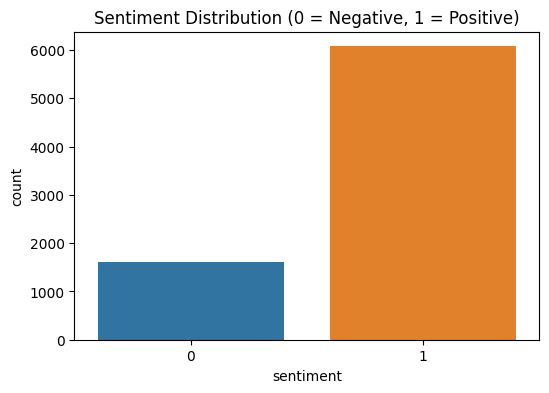

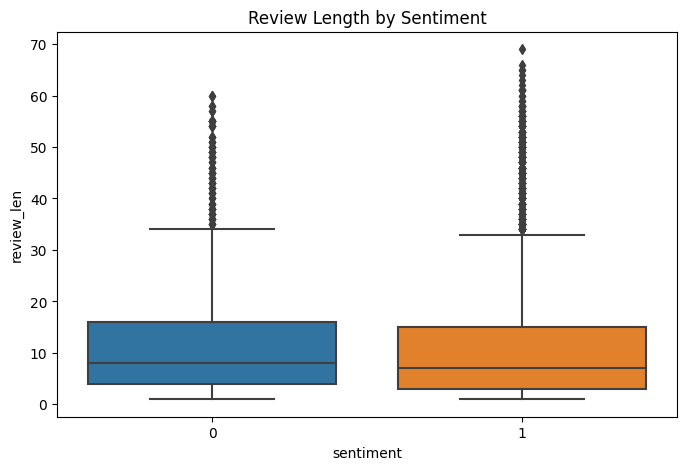

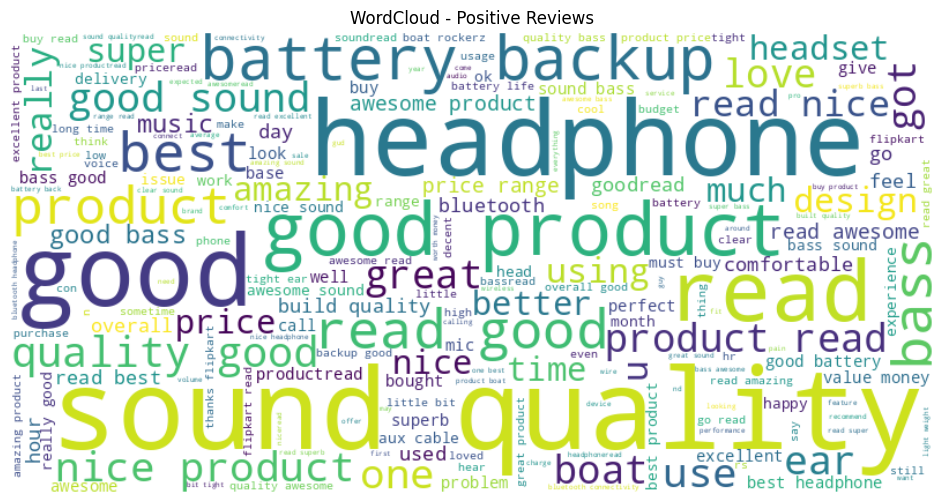

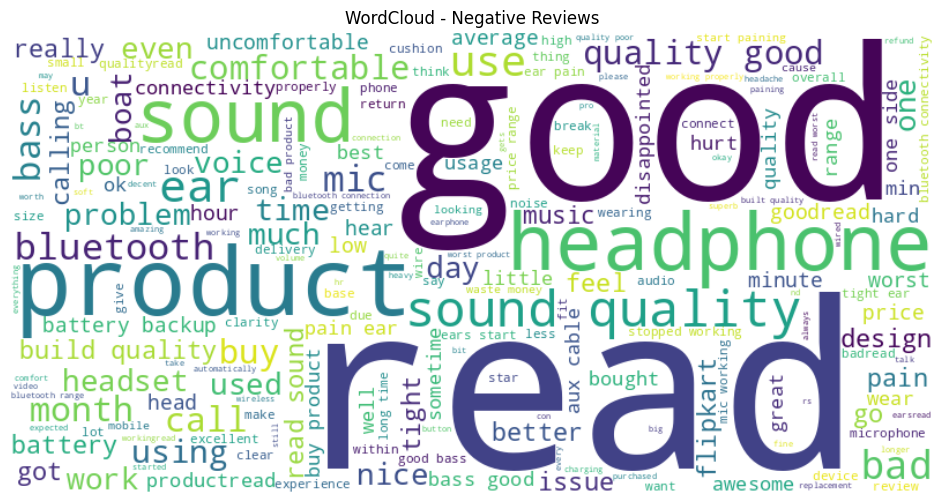

In [27]:
# 7️⃣ EXPLORATORY DATA ANALYSIS
plt.figure(figsize=(6,4))
sns.countplot(x=LABEL_COL, data=df)
plt.title('Sentiment Distribution (0 = Negative, 1 = Positive)')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=LABEL_COL, y='review_len', data=df)
plt.title('Review Length by Sentiment')
plt.show()

positive_text = ' '.join(df[df[LABEL_COL]==1]['clean_text'])
negative_text = ' '.join(df[df[LABEL_COL]==0]['clean_text'])

if len(positive_text) > 0:
    wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud - Positive Reviews')
    plt.show()

if len(negative_text) > 0:
    wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud - Negative Reviews')
    plt.show()


In [28]:
# 8️⃣ TRAIN-TEST SPLIT
X = df['clean_text']
y = df[LABEL_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n📦 Train size: {len(X_train)}, Test size: {len(X_test)}")


📦 Train size: 6155, Test size: 1539


In [29]:
# 9️⃣ MODEL TRAINING
TFIDF = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=5)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': MultinomialNB(),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'LinearSVC': LinearSVC(max_iter=5000)
}

results = []
for name, clf in models.items():
    print(f"\n🚀 Training {name}...")
    pipe = Pipeline([('tfidf', TFIDF), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}")
    results.append({'model': name, 'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec, 'pipeline': pipe})

res_df = pd.DataFrame(results).sort_values(by='f1', ascending=False).reset_index(drop=True)
print('\n🏁 Model Comparison:')
print(res_df[['model', 'accuracy', 'f1', 'precision', 'recall']])

best_model = res_df.loc[0, 'pipeline']
best_name = res_df.loc[0, 'model']

print(f"\n⭐ Best Model: {best_name}")


🚀 Training LogisticRegression...
LogisticRegression → Accuracy: 0.8700, F1: 0.9219

🚀 Training NaiveBayes...
NaiveBayes → Accuracy: 0.8525, F1: 0.9118

🚀 Training RandomForest...
RandomForest → Accuracy: 0.8720, F1: 0.9222

🚀 Training LinearSVC...
LinearSVC → Accuracy: 0.8661, F1: 0.9177

🏁 Model Comparison:
                model  accuracy        f1  precision    recall
0        RandomForest  0.871995  0.922165   0.886778  0.960494
1  LogisticRegression  0.870045  0.921875   0.877323  0.971193
2           LinearSVC  0.866147  0.917732   0.891389  0.945679
3          NaiveBayes  0.852502  0.911845   0.863235  0.966255

⭐ Best Model: RandomForest



Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.54      0.64       324
           1       0.89      0.96      0.92      1215

    accuracy                           0.87      1539
   macro avg       0.84      0.75      0.78      1539
weighted avg       0.87      0.87      0.86      1539



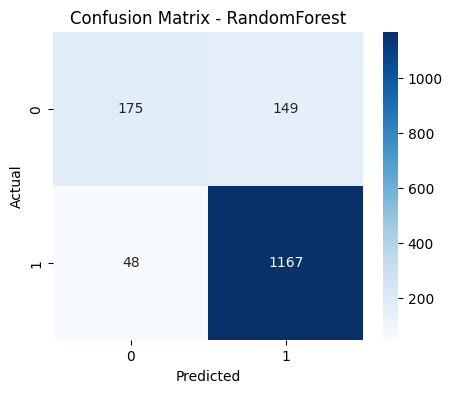

In [30]:
# 🔟 MODEL EVALUATION
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()


In [31]:
# 11 💾 Save model comparison results to CSV
results_csv_path = '/kaggle/working/model_results.csv'
res_df[['model', 'accuracy', 'f1', 'precision', 'recall']].to_csv(results_csv_path, index=False)
print(f"\n📁 Model results saved successfully to: {results_csv_path}")


📁 Model results saved successfully to: /kaggle/working/model_results.csv


In [32]:
# 1️⃣2️⃣ TEST ON NEW REVIEWS
sample_reviews = [
    "This phone has excellent battery life and a crisp display. Totally worth the price!",
    "Terrible experience — the product stopped working after two days and customer service was useless."
]

sample_clean = [clean_text(r) for r in sample_reviews]
preds = best_model.predict(sample_clean)

print("\n🧪 Testing on sample reviews:")
for review, sentiment in zip(sample_reviews, preds):
    print('\nReview:', review)
    print('Predicted Sentiment:', 'Positive' if sentiment == 1 else 'Negative')

print('\n✅ All done! You can now explore the results and model output in Kaggle.')



🧪 Testing on sample reviews:

Review: This phone has excellent battery life and a crisp display. Totally worth the price!
Predicted Sentiment: Positive

Review: Terrible experience — the product stopped working after two days and customer service was useless.
Predicted Sentiment: Negative

✅ All done! You can now explore the results and model output in Kaggle.


In [33]:
import pandas as pd
df.head(10)


,review,rating,sentiment,clean_text,review_len
0,It was nice produt. I like it's design a lot. ...,5,1,nice produt like design lot easy carry looked ...,10
1,awesome sound....very pretty to see this nd th...,5,1,awesome sound pretty see nd sound quality good...,14
2,awesome sound quality. pros 7-8 hrs of battery...,4,1,awesome sound quality pros 7 8 hrs battery lif...,59
3,I think it is such a good product not only as ...,5,1,think good product per quality also design qui...,35
4,awesome bass sound quality very good bettary l...,5,1,awesome bass sound quality good bettary long l...,16
5,Awsome sound powerful bass battery backup is a...,5,1,awsome sound powerful bass battery backup also...,47
6,This product sound is clear and excellent bass...,4,1,product sound clear excellent bass obviously g...,16
7,Should u buy this---Pros:-1. Sound quality and...,4,1,u buy pros 1 sound quality build quality aweso...,58
8,"First of all, I want to talk about sound quali...",5,1,first want talk sound quality sound quality be...,53
9,Good looking Super Fine clear Sound and power ...,5,1,good looking super fine clear sound power full...,9
